## YOLOv3

In [1]:

# 0) 환경
import os, json, math, random, shutil, zipfile, gc
from pathlib import Path
import numpy as np
from PIL import Image, ImageOps, ImageEnhance, ImageDraw, ImageFont
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
INPUT_SIZE = 416
SCALES = [13,26,52]
STRIDES = [32,16,8]
ANCHORS = [(10,13),(16,30),(33,23),(30,61),(62,45),(59,119),(116,90),(156,198),(373,326)]
ANCHORS_SCALED = {52:ANCHORS[0:3], 26:ANCHORS[3:6], 13:ANCHORS[6:9]}

print('DEVICE =', DEVICE)


DEVICE = cuda


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

# 1) drawings.zip unzip
zip_candidates = [Path("/content/drive/MyDrive/AI활용 소프트웨어 개발/13. 생성형 AI/data/drawings.zip")]
zip_path = None
for c in zip_candidates:
    if c.exists():
        zip_path = c; break
assert zip_path is not None, "drawings.zip을 같은 경로에 업로드하세요."

root = Path("./data_drawings_v3_fixed")
if root.exists(): shutil.rmtree(root)
root.mkdir(parents=True, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zf:
    zf.extractall(root)

# 원천/라벨 폴더 유추
src_dir = None; lbl_dir = None
for p in root.rglob("*"):
    if p.is_dir() and "원천" in p.name:
        src_dir = p
    if p.is_dir() and "라벨" in p.name:
        lbl_dir = p
if lbl_dir is None:
    # json이 있는 곳을 라벨로
    cand = list(root.rglob("*.json"))
    assert cand, "라벨 JSON을 찾을 수 없습니다."
    lbl_dir = cand[0].parent
if src_dir is None:
    # 이미지 폴더 최상위 추정
    imgs = list(root.rglob("*.jpg")) + list(root.rglob("*.png"))
    assert imgs, "이미지 파일을 찾을 수 없습니다."
    src_dir = imgs[0].parents[2] if len(imgs[0].parents)>=2 else root

print("src_dir:", src_dir)
print("lbl_dir:", lbl_dir)

def letterbox(im, new_size=INPUT_SIZE, color=(114,114,114)):
    w,h = im.size
    s = min(new_size/w, new_size/h)
    nw, nh = int(w*s), int(h*s)
    im_r = im.resize((nw,nh), Image.BILINEAR)
    canvas = Image.new('RGB', (new_size,new_size), color)
    pad_x = (new_size-nw)//2; pad_y=(new_size-nh)//2
    canvas.paste(im_r, (pad_x,pad_y))
    return canvas, s, pad_x, pad_y


src_dir: data_drawings_v3_fixed/Sample/01.원천데이터
lbl_dir: data_drawings_v3_fixed/Sample/02.라벨링데이터


In [4]:

# 2) JSON 파싱 (경로 복구 강력)
def resolve_img_path(rel_or_name: str):
    p = (lbl_dir / rel_or_name).resolve()
    if p.exists():
        return p
    # 이름으로 전체 검색
    name = Path(rel_or_name).name
    for ext in ["*.jpg","*.jpeg","*.png","*.bmp"]:
        hits = list(root.rglob(ext))
        hits = [h for h in hits if h.name == name]
        if hits:
            return hits[0]
    # 마지막 시도: 동일 stem
    stem = Path(rel_or_name).stem
    hits = [h for h in root.rglob("*.*") if h.stem == stem and h.suffix.lower() in [".jpg",".jpeg",".png",".bmp"]]
    if hits:
        return hits[0]
    return None

def parse_json(json_path):
    with open(json_path, "r", encoding="utf-8") as f:
        d = json.load(f)
    meta = d.get("meta", {})
    anns = d.get("annotations", {})
    bboxes = anns.get("bbox", [])
    img_rel = meta.get("img_path") or meta.get("image_path") or meta.get("file_path")
    img_path = resolve_img_path(img_rel if img_rel else Path(json_path).with_suffix(".jpg").name)
    return {"img_path": img_path, "bboxes": bboxes}

json_list = sorted(lbl_dir.rglob("*.json"))
items = []
from collections import Counter
label_counter = Counter()

for jp in json_list:
    info = parse_json(jp)
    if info["img_path"] is None or not Path(info["img_path"]).exists():
        continue
    # 표준화: bbox dict: x,y,w,h,label
    fixed = []
    for bb in info["bboxes"]:
        x = float(bb.get("x", bb.get("left", 0)))
        y = float(bb.get("y", bb.get("top", 0)))
        w = float(bb.get("w", bb.get("width", 0)))
        h = float(bb.get("h", bb.get("height", 0)))
        lab = bb.get("label", "unknown")
        if w>0 and h>0:
            fixed.append({"x":x,"y":y,"w":w,"h":h,"label":lab})
            label_counter[lab]+=1
    if fixed:
        items.append({"img_path": info["img_path"], "bboxes": fixed})

assert items, "유효 라벨이 없습니다."
classes = sorted(label_counter.keys())
cls2idx = {c:i for i,c in enumerate(classes)}
idx2cls = {i:c for c,i in cls2idx.items()}
num_classes = len(classes)
print("items:", len(items), "classes:", num_classes)
print("top labels:", label_counter.most_common(10))


items: 560 classes: 47
top labels: [('꽃', 637), ('눈', 560), ('팔', 560), ('발', 560), ('운동화', 560), ('다리', 559), ('귀', 557), ('손', 557), ('잔디', 525), ('주머니', 517)]


In [5]:
# =========================
# 3) Dataset (YOLOv3 강화판)
# =========================
import math, random, numpy as np, torch
from PIL import Image, ImageEnhance
from torch.utils.data import DataLoader

# ──[필요 상수: 프로젝트에 기존에 있다면 이 블록은 건너뛰어도 됨]──────────────────
# 예) SCALES, STRIDES, INPUT_SIZE, cls2idx, num_classes, items 등
try:
    SCALES
except NameError:
    SCALES = [52, 26, 13]   # YOLOv3 출력 스케일

try:
    STRIDES
except NameError:
    # 입력이 416이면 stride는 8/16/32 → 416/52=8, 416/26=16, 416/13=32
    INPUT_SIZE = globals().get("INPUT_SIZE", 416)
    STRIDES = [INPUT_SIZE//S for S in SCALES]

# YOLOv3 COCO 기본 앵커(416 기준, pixel). 이미 있다면 그대로 사용.
try:
    ANCHORS
except NameError:
    ANCHORS = np.array([
        [10,13],[16,30],[33,23],
        [30,61],[62,45],[59,119],
        [116,90],[156,198],[373,326]
    ], np.float32)

# 스케일별로 어떤 앵커를 쓸지(논문/공용 구현 관례). 이미 있으면 그대로 사용.
try:
    ANCHOR_MASKS
except NameError:
    ANCHOR_MASKS = {52:[0,1,2], 26:[3,4,5], 13:[6,7,8]}

# 스케일별 앵커 배열이 이미 계산돼 있다면(예: ANCHORS_SCALED[S] == (3,2)),
# 그대로 사용하고, 없으면 여기서 만들어 준다.
try:
    ANCHORS_SCALED
except NameError:
    ANCHORS_SCALED = {S: ANCHORS[np.array(ANCHOR_MASKS[S])].astype(np.float32) for S in SCALES}

# ──[보조: wh-IoU와 xywh-IoU]────────────────────────────────────────────────────
def _iou_wh(w1, h1, w2, h2, eps=1e-9):
    """너비/높이만으로 IoU 근사(중심 동일 가정). 앵커-박스 매칭용."""
    inter = min(w1, w2) * min(h1, h2)
    union = w1*h1 + w2*h2 - inter + eps
    return inter / union

def _iou_xywh(b1, b2, eps=1e-9):
    """[cx,cy,w,h] vs [cx,cy,w,h] IoU (절대좌표, 픽셀)"""
    x1min = b1[0]-b1[2]/2; y1min = b1[1]-b1[3]/2
    x1max = b1[0]+b1[2]/2; y1max = b1[1]+b1[3]/2
    x2min = b2[0]-b2[2]/2; y2min = b2[1]-b2[3]/2
    x2max = b2[0]+b2[2]/2; y2max = b2[1]+b2[3]/2
    iw = max(0.0, min(x1max,x2max) - max(x1min,x2min))
    ih = max(0.0, min(y1max,y2max) - max(y1min,y2min))
    inter = iw*ih
    area1 = max(0.0, x1max-x1min) * max(0.0, y1max-y1min)
    area2 = max(0.0, x2max-x2min) * max(0.0, y2max-y2min)
    union = area1 + area2 - inter + eps
    return inter / union

# ──[타깃 생성: 논문 방식으로 개선]───────────────────────────────────────────────
def build_targets_yolov3(bboxes, num_classes):
    """
    입력: bboxes = [{'x','y','w','h','label'}]  (이미 letterbox로 416 좌표계로 보정된 상태)
    출력: {S: (S, S, 3, 5+num_classes)}  (tx,ty,tw,th,obj, one-hot...)

    ✅ 개선 포인트
      1) 9개 앵커(전역)과 wh-IoU 비교 → argmax로 '전역 베스트 앵커' 선택
      2) 그 앵커가 속한 스케일(마스크)에만 1곳 할당 (논문 스타일)
      3) gx, gy 경계 클램프
      4) 동일 (S, gx, gy, anchor) 충돌 시 → GT와 셀센터 IoU 큰 쪽 유지
    """
    INPUT_SIZE = globals().get("INPUT_SIZE", 416)

    targets = {S: np.zeros((S, S, 3, 5+num_classes), np.float32) for S in SCALES}
    # 충돌 우선순위 판단용으로, 같은 위치에 이미 들어간 GT의 IoU를 기억
    filled_iou = {S: np.full((S, S, 3), -1.0, np.float32) for S in SCALES}

    for bb in bboxes:
        x, y, w, h, lab = bb["x"], bb["y"], bb["w"], bb["h"], bb["label"]
        cx, cy = x + w/2, y + h/2

        # 1) 전역 앵커 IoU 비교(wh 기준)
        ious = np.array([_iou_wh(w, h, aw, ah) for (aw,ah) in ANCHORS], np.float32)
        best_idx = int(np.argmax(ious))  # 전역 베스트 앵커 인덱스(0~8)

        # 2) 스케일/로컬 앵커 찾기
        if best_idx in ANCHOR_MASKS[52]:
            S = 52; a_local = ANCHOR_MASKS[52].index(best_idx)
        elif best_idx in ANCHOR_MASKS[26]:
            S = 26; a_local = ANCHOR_MASKS[26].index(best_idx)
        else:
            S = 13; a_local = ANCHOR_MASKS[13].index(best_idx)

        stride = INPUT_SIZE // S
        gx = int(cx // stride)
        gy = int(cy // stride)

        # 3) 경계 클램프 (letterbox 경계 근처 박스 안전 처리)
        if gx < 0 or gy < 0 or gx >= S or gy >= S:
            # 경계 바깥이면 스킵(혹은 clamp로 밀어넣을 수도 있음)
            continue

        # 4) YOLO 파라미터화
        tx = (cx / stride) - gx
        ty = (cy / stride) - gy
        # 주의: YOLOv3는 앵커 크기(픽셀)를 입력 크기 기준으로 고정 사용
        aw, ah = ANCHORS[best_idx]
        tw = math.log(max(w, 1e-6) / aw)
        th = math.log(max(h, 1e-6) / ah)

        T = targets[S]

        # 5) 동일 곳 충돌 시, '셀 중심 기준 IoU'가 큰 GT를 남긴다(간단/효과적)
        #    비교 대상: 같은 (S, gy, gx, a_local)
        prev_iou = filled_iou[S][gy, gx, a_local]
        curr_iou = _iou_xywh([cx,cy,w,h], [(gx+tx)*stride, (gy+ty)*stride, aw*math.exp(tw), ah*math.exp(th)])
        if curr_iou <= prev_iou:
            # 기존 것이 더 낫다 → 이번 GT는 스킵
            continue

        # 6) 기록
        T[gy, gx, a_local, 0] = tx
        T[gy, gx, a_local, 1] = ty
        T[gy, gx, a_local, 2] = tw
        T[gy, gx, a_local, 3] = th
        T[gy, gx, a_local, 4] = 1.0  # objectness

        cid = globals().get("cls2idx", {}).get(lab, -1) if isinstance(lab, (str,)) else int(lab)
        if 0 <= cid < num_classes:
            T[gy, gx, a_local, 5 + cid] = 1.0

        filled_iou[S][gy, gx, a_local] = curr_iou

    return targets

# ──[letterbox: 비율 유지 resize + pad, 좌표 보정용 s/px/py 반환]──────────────────
def letterbox(im, new_size=None, color=(114,114,114)):
    """
    비율 유지하여 new_size x new_size로 맞추고, 남는 부분은 color로 패딩.
    반환: (캔버스이미지, scale s, pad_x px, pad_y py)
    """
    INPUT_SIZE = globals().get("INPUT_SIZE", 416)
    if new_size is None:
        new_size = INPUT_SIZE

    w, h = im.size
    s = min(new_size / w, new_size / h)
    nw, nh = int(w * s), int(h * s)
    im_r = im.resize((nw, nh), Image.BILINEAR)
    canvas = Image.new('RGB', (new_size, new_size), color)
    px = (new_size - nw) // 2
    py = (new_size - nh) // 2
    canvas.paste(im_r, (px, py))
    return canvas, s, px, py

# ──[간단 증강 훅(옵션): 수평 뒤집기 + 채도/밝기]────────────────────────────────
def _maybe_hflip(im, bboxes, p=0.5):
    if random.random() >= p:
        return im, bboxes
    W, H = im.size
    im = im.transpose(Image.FLIP_LEFT_RIGHT)
    flipped = []
    for bb in bboxes:
        x, y, w, h, lab = bb["x"], bb["y"], bb["w"], bb["h"], bb["label"]
        nx = W - (x + w)  # 좌우 반전: 새 x는 오른쪽에서 w만큼 뺀 위치
        flipped.append({"x":nx, "y":y, "w":w, "h":h, "label":lab})
    return im, flipped

def _maybe_color(im, p=0.5, vgain=0.4, sgain=0.6):
    if random.random() >= p:
        return im
    # S(채도)/V(밝기)만 간단히
    im = ImageEnhance.Color(im).enhance(1.0 + random.uniform(-sgain, sgain))
    im = ImageEnhance.Brightness(im).enhance(1.0 + random.uniform(-vgain, vgain))
    return im

# ──[Dataset 클래스]────────────────────────────────────────────────────────────
class DS(torch.utils.data.Dataset):
    """
    items: [{"img_path": str, "bboxes": [{"x","y","w","h","label"}, ...]}, ...]
      - 주의: bboxes는 '원본 이미지' 좌표 (pixel) 기준.
      - 이 클래스 내부에서 letterbox(scale+pad) 후, 416 좌표로 보정해서 타깃 생성.
    augment: True면 간단한 hflip/color 증강(옵션) 사용.
    """
    def __init__(self, items, augment=True):
        self.items = items
        self.augment = augment
        self.INPUT_SIZE = globals().get("INPUT_SIZE", 416)
        self.num_classes = globals().get("num_classes", 0)

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        it = self.items[idx]
        im = Image.open(it["img_path"]).convert("RGB")
        bbs = it["bboxes"]

        # (옵션) 아주 가벼운 증강 — 원본 좌표 기준에서 먼저 적용
        if self.augment:
            im, bbs = _maybe_hflip(im, bbs, p=0.50)
            im = _maybe_color(im, p=0.30)

        # letterbox로 입력 크기(예: 416) 맞춤
        im_lb, s, px, py = letterbox(im, self.INPUT_SIZE)

        # 원본 좌표 → 416 좌표로 보정
        fixed = []
        for bb in bbs:
            x = bb["x"]*s + px
            y = bb["y"]*s + py
            w = bb["w"]*s
            h = bb["h"]*s
            fixed.append({"x":x,"y":y,"w":w,"h":h,"label":bb["label"]})

        # YOLOv3 타깃 생성(논문식으로 개선)
        T = build_targets_yolov3(fixed, self.num_classes)

        # 이미지를 텐서(C,H,W, float32 [0,1])로 변환
        arr = np.asarray(im_lb, np.float32) / 255.0      # (H,W,3)
        arr = np.transpose(arr, (2,0,1))                 # (3,H,W)
        img = torch.from_numpy(arr)

        # 스케일별 타깃을 텐서로 변환
        targets = {S: torch.from_numpy(T[S]) for S in SCALES}
        return img, targets

# ──[split & DataLoader]────────────────────────────────────────────────────────
random.seed(0)
perm = list(range(len(items)))
random.shuffle(perm)
cut = int(len(perm)*0.9) if len(perm) > 1 else len(perm)
train_items = [items[i] for i in perm[:cut]]
val_items   = [items[i] for i in perm[cut:]]

train_loader = DataLoader(
    DS(train_items, augment=True),
    batch_size=8, shuffle=True, num_workers=2, pin_memory=True
)
val_loader = DataLoader(
    DS(val_items, augment=False),
    batch_size=8, shuffle=False, num_workers=2, pin_memory=True
)

print("train/val:", len(train_items), len(val_items))


train/val: 504 56


In [6]:

# 4) 모델
def conv_bn_act(c_in, c_out, k=3, s=1, p=None):
    if p is None: p=(k-1)//2
    return nn.Sequential(
        nn.Conv2d(c_in,c_out,k,s,p,bias=False),
        nn.BatchNorm2d(c_out),
        nn.LeakyReLU(0.1, inplace=True),
    )

class ResBlk(nn.Module):
    def __init__(self,c):
        super().__init__()
        self.c1=conv_bn_act(c,c//2,1,1,0)
        self.c2=conv_bn_act(c//2,c,3,1,1)
    def forward(self,x):
        return x + self.c2(self.c1(x))

class Darknet53(nn.Module):
    def __init__(self):
        super().__init__()
        self.s=conv_bn_act(3,32,3,1)
        self.d1=nn.Sequential(conv_bn_act(32,64,3,2), ResBlk(64))
        self.d2=nn.Sequential(conv_bn_act(64,128,3,2), *[ResBlk(128) for _ in range(2)])
        self.d3=nn.Sequential(conv_bn_act(128,256,3,2), *[ResBlk(256) for _ in range(8)])
        self.d4=nn.Sequential(conv_bn_act(256,512,3,2), *[ResBlk(512) for _ in range(8)])
        self.d5=nn.Sequential(conv_bn_act(512,1024,3,2), *[ResBlk(1024) for _ in range(4)])
    def forward(self,x):
        x=self.s(x); x=self.d1(x); x=self.d2(x)
        x52=self.d3(x); x26=self.d4(x52); x13=self.d5(x26)
        return x13,x26,x52

def yolo_head(c_in, c_out):
    seq = nn.Sequential(
        conv_bn_act(c_in,512,1,1,0),
        conv_bn_act(512,1024,3,1,1),
        conv_bn_act(1024,512,1,1,0),
        conv_bn_act(512,1024,3,1,1),
        conv_bn_act(1024,512,1,1,0),
    )
    pred = nn.Conv2d(512, c_out, 1,1,0)
    return seq, pred

class YOLOv3(nn.Module):
    def __init__(self, C):
        super().__init__()
        self.C=C
        self.back=Darknet53()
        # heads
        self.h13,self.p13=yolo_head(1024, 3*(5+C))
        self.red26=conv_bn_act(512,256,1,1,0)   # ← head13 출력(512ch)을 256으로 축소
        self.h26,self.p26=yolo_head(512+256, 3*(5+C))
        self.red52=conv_bn_act(512,128,1,1,0)   # ← head26 출력(512ch)을 128로 축소
        self.h52,self.p52=yolo_head(256+128, 3*(5+C))
        self.up=nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self,x):
        # 백본
        x13,x26,x52=self.back(x)   # x13: (N,1024,13,13), x26: (N,512,26,26), x52: (N,256,52,52)

        # 13x13 헤드
        h13=self.h13(x13)          # (N,512,13,13)
        p13=self.p13(h13)          # (N,3*(5+C),13,13)

        # 26x26 헤드: (h13 → 256 → 업샘플 26) ⊕ x26
        route26 = self.red26(h13)  # (N,256,13,13)
        u26 = self.up(route26)     # (N,256,26,26)
        h26 = torch.cat([u26, x26], dim=1)   # (N,256+512,26,26)
        h26 = self.h26(h26)        # (N,512,26,26)
        p26 = self.p26(h26)        # (N,3*(5+C),26,26)

        # 52x52 헤드: (h26 → 128 → 업샘플 52) ⊕ x52
        route52 = self.red52(h26)  # (N,128,26,26)
        u52 = self.up(route52)     # (N,128,52,52)
        h52 = torch.cat([u52, x52], dim=1)   # (N,128+256,52,52)
        h52 = self.h52(h52)        # (N,256,52,52)
        p52 = self.p52(h52)        # (N,3*(5+C),52,52)

        # reshape: (N,3,S,S,5+C)
        def reshape(p,S):
            N=p.shape[0]; A=3; C=5+self.C
            return p.view(N,A,C,S,S).permute(0,1,3,4,2).contiguous()

        return {13:reshape(p13,13), 26:reshape(p26,26), 52:reshape(p52,52)}

model = YOLOv3(len(classes)).to(DEVICE)
print("params(M):", sum(p.numel() for p in model.parameters())/1e6)


params(M): 73.615284


In [7]:

# 5) 손실
class LossV3(nn.Module):
    def __init__(self, C, lambda_noobj=1.0):
        super().__init__(); self.C=C; self.lambda_noobj=lambda_noobj
    def forward(self, preds, tgts):
        tot=0.0; comp={"coord":0.0,"obj":0.0,"noobj":0.0,"cls":0.0}
        for S in [13,26,52]:
            p = preds[S]                 # (N,3,S,S,5+C)
            t = tgts[S].permute(0,3,1,2,4).to(p.device)  # (N,3,S,S,5+C)
            obj = t[...,4]==1.0
            no  = t[...,4]==0.0
            if obj.any():
                lxy = F.mse_loss(torch.sigmoid(p[...,0][obj]), t[...,0][obj], reduction='sum') + \
                      F.mse_loss(torch.sigmoid(p[...,1][obj]), t[...,1][obj], reduction='sum')
                lwh = F.mse_loss(p[...,2][obj], t[...,2][obj], reduction='sum') + \
                      F.mse_loss(p[...,3][obj], t[...,3][obj], reduction='sum')
                lobj= F.binary_cross_entropy_with_logits(p[...,4][obj], torch.ones_like(p[...,4][obj]), reduction='sum')
                lcls= F.binary_cross_entropy_with_logits(p[...,5:][obj], t[...,5:][obj], reduction='sum')
            else:
                lxy=lwh=lobj=lcls=torch.tensor(0.0, device=p.device)
            lno = F.binary_cross_entropy_with_logits(p[...,4][no], torch.zeros_like(p[...,4][no]), reduction='sum') if no.any() else torch.tensor(0.0, device=p.device)
            loss = lxy + lwh + lobj + self.lambda_noobj*lno + lcls
            tot = tot + loss
            comp["coord"]+=float((lxy+lwh).item()); comp["obj"]+=float(lobj.item()); comp["noobj"]+=float(lno.item()); comp["cls"]+=float(lcls.item())
        return tot/preds[13].shape[0], comp

criterion = LossV3(len(classes)).to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)


In [8]:

# 6) 퀵 학습 루프(원하면 EPOCHS ↑)
from tqdm import tqdm
def train_ep():
    model.train(); total=0.0
    for x,t in tqdm(train_loader, desc="train"):
        x=x.to(DEVICE).float()
        tt={S:t[S].to(DEVICE).float() for S in SCALES}
        p=model(x)
        loss,comp=criterion(p,tt)
        opt.zero_grad(); loss.backward(); torch.nn.utils.clip_grad_norm_(model.parameters(),5.0); opt.step()
        total += loss.item()
    return total/len(train_loader)
@torch.no_grad()
def val_ep():
    model.eval(); total=0.0
    for x,t in val_loader:
        x=x.to(DEVICE).float(); tt={S:t[S].to(DEVICE).float() for S in SCALES}
        p=model(x); loss,_=criterion(p,tt); total+=loss.item()
    return total/len(val_loader)

EPOCHS=50  # 데모. 실제로는 20~100
for ep in range(1,EPOCHS+1):
    tl=train_ep(); vl=val_ep()
    print(f"[{ep:02d}] train={tl:.3f} val={vl:.3f}")


train: 100%|██████████| 63/63 [00:43<00:00,  1.46it/s]


[01] train=963.271 val=282.319


train: 100%|██████████| 63/63 [00:43<00:00,  1.44it/s]


[02] train=208.395 val=237.596


train: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s]


[03] train=184.165 val=257.352


train: 100%|██████████| 63/63 [00:45<00:00,  1.38it/s]


[04] train=167.337 val=279.565


train: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s]


[05] train=157.347 val=283.470


train: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s]


[06] train=144.782 val=299.135


train: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s]


[07] train=137.340 val=284.484


train: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s]


[08] train=131.146 val=313.555


train: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s]


[09] train=125.090 val=258.070


train: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s]


[10] train=125.076 val=300.606


train: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s]


[11] train=114.334 val=274.411


train: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s]


[12] train=111.239 val=292.842


train: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s]


[13] train=107.256 val=282.202


train: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s]


[14] train=104.341 val=271.089


train: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s]


[15] train=100.335 val=283.477


train: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s]


[16] train=97.260 val=337.741


train: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s]


[17] train=95.195 val=233.221


train: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s]


[18] train=92.020 val=285.430


train: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s]


[19] train=90.970 val=281.424


train: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s]


[20] train=89.213 val=246.566


train: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s]


[21] train=85.302 val=243.089


train: 100%|██████████| 63/63 [00:46<00:00,  1.37it/s]


[22] train=81.923 val=223.021


train: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s]


[23] train=78.897 val=318.108


train: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s]


[24] train=77.475 val=263.646


train: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s]


[25] train=76.124 val=122.522


train: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s]


[26] train=73.345 val=304.909


train: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s]


[27] train=69.796 val=178.397


train: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s]


[28] train=70.253 val=166.826


train: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s]


[29] train=65.279 val=161.765


train: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s]


[30] train=63.797 val=210.805


train: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s]


[31] train=60.526 val=112.573


train: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s]


[32] train=59.859 val=349.961


train: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s]


[33] train=58.444 val=334.810


train: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s]


[34] train=55.521 val=258.404


train: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s]


[35] train=52.602 val=210.401


train: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s]


[36] train=52.570 val=314.633


train: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s]


[37] train=49.804 val=214.111


train: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s]


[38] train=47.180 val=253.323


train: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s]


[39] train=47.296 val=343.744


train: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s]


[40] train=44.120 val=236.150


train: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s]


[41] train=43.309 val=310.460


train: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s]


[42] train=40.223 val=179.102


train: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s]


[43] train=38.994 val=284.786


train: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s]


[44] train=39.700 val=334.462


train: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s]


[45] train=37.435 val=307.134


train: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s]


[46] train=35.902 val=296.871


train: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s]


[47] train=32.749 val=190.268


train: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s]


[48] train=32.552 val=120.566


train: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s]


[49] train=32.184 val=263.490


train: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s]


[50] train=30.867 val=160.277


In [9]:
# 1. Noto CJK (중국어, 일본어, 한국어) 폰트 설치
#    - Google에서 배포하는 CJK 전용 폰트 패키지
!apt-get -y install fonts-noto-cjk
# 2. 폰트 캐시 갱신
#    - 새로 설치한 폰트를 시스템에 반영하기 위해 실행
!fc-cache -fv

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  fonts-noto-cjk-extra
The following NEW packages will be installed:
  fonts-noto-cjk
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 61.2 MB of archives.
After this operation, 93.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-noto-cjk all 1:20220127+repack1-1 [61.2 MB]
Fetched 61.2 MB in 6s (11.0 MB/s)
Selecting previously unselected package fonts-noto-cjk.
(Reading database ... 126371 files and directories currently installed.)
Preparing to unpack .../fonts-noto-cjk_1%3a20220127+repack1-1_all.deb ...
Unpacking fonts-noto-cjk (1:20220127+repack1-1) ...
Setting up fonts-noto-cjk (1:20220127+repack1-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/opentype: caching, new cache contents: 0 fon

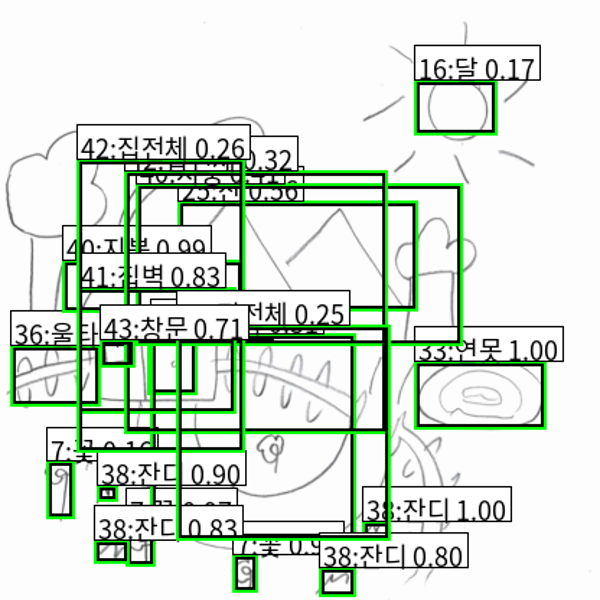

In [10]:

# 7) 추론 + 시각화(한글)
def _get_font(size=18):
    paths=[
        "/usr/share/fonts/truetype/noto/NotoSansCJK-Regular.ttc",
        "/Library/Fonts/AppleGothic.ttf",
        "C:/Windows/Fonts/malgun.ttf",
    ]
    for p in paths:
        try: return ImageFont.truetype(p,size)
        except: pass
    return ImageFont.load_default()

def nms_np(boxes, scores, iou_th=0.5):
    if len(boxes)==0: return []
    idxs=np.argsort(-scores); keep=[]
    def iou(a,b):
        ax1,ay1,ax2,ay2=a; bx1,by1,bx2,by2=b
        ix1=max(ax1,bx1); iy1=max(ay1,by1); ix2=min(ax2,bx2); iy2=min(ay2,by2)
        iw=max(0.0, ix2-ix1); ih=max(0.0, iy2-iy1); inter=iw*ih
        areaA=(ax2-ax1)*(ay2-ay1); areaB=(bx2-bx1)*(by2-by1)
        return inter/(areaA+areaB-inter+1e-9)
    while len(idxs)>0:
        i=idxs[0]; keep.append(i)
        rest=idxs[1:]
        idxs=np.array([j for j in rest if iou(boxes[i], boxes[j])<iou_th], dtype=np.int64)
    return keep

@torch.no_grad()
def infer_image(img_path, conf_th=0.15, iou_th=0.45):
    im=Image.open(img_path).convert("RGB")
    im_lb,s,px,py=letterbox(im, INPUT_SIZE)
    arr=np.transpose(np.asarray(im_lb,np.float32)/255.0,(2,0,1))
    t=torch.from_numpy(arr).unsqueeze(0).to(DEVICE)
    out=model(t)  # dict
    boxes_all=[]; scores_all=[]; labels_all=[]
    for S in [13,26,52]:
        pred=out[S][0].cpu().numpy()  # (3,S,S,5+C)
        stride=INPUT_SIZE//S; anchors=np.array(ANCHORS_SCALED[S],np.float32)
        for a in range(3):
            for gy in range(S):
                for gx in range(S):
                    tx,ty,tw,th,to = pred[a,gy,gx,:5]
                    obj=1/(1+np.exp(-to))
                    cls_logits=pred[a,gy,gx,5:]
                    cls_prob=1/(1+np.exp(-cls_logits))
                    cidx=int(np.argmax(cls_prob)) if cls_prob.size>0 else 0
                    conf=obj*(cls_prob[cidx] if cls_prob.size>0 else obj)
                    if conf < conf_th: continue
                    cx=(1/(1+np.exp(-tx))+gx)*stride; cy=(1/(1+np.exp(-ty))+gy)*stride
                    bw=anchors[a,0]*np.exp(tw); bh=anchors[a,1]*np.exp(th)
                    x1,y1,x2,y2=cx-bw/2, cy-bh/2, cx+bw/2, cy+bh/2
                    boxes_all.append([x1,y1,x2,y2]); scores_all.append(float(conf)); labels_all.append(cidx)
    if len(boxes_all)==0:
        return im_lb, ([],[],[])
    boxes_all=np.array(boxes_all,np.float32); scores_all=np.array(scores_all,np.float32); labels_all=np.array(labels_all,np.int32)
    final_boxes=[]; final_scores=[]; final_labels=[]
    for c in np.unique(labels_all):
        idxs=np.where(labels_all==c)[0]; keep=nms_np(boxes_all[idxs], scores_all[idxs], iou_th)
        for k in keep:
            final_boxes.append(boxes_all[idxs][k].tolist()); final_scores.append(float(scores_all[idxs][k])); final_labels.append(int(c))
    draw=im_lb.copy(); dr=ImageDraw.Draw(draw); font=_get_font(18)
    W,H=draw.size; th=max(2,int(max(W,H)/512*2)); pad=3
    for (x1,y1,x2,y2),s,c in zip(final_boxes,final_scores,final_labels):
        dr.rectangle([x1,y1,x2,y2], outline=(0,0,0), width=th+2)
        dr.rectangle([x1,y1,x2,y2], outline=(0,255,0), width=th)
        text=f"{c}:{classes[c]} {s:.2f}"
        tx1,ty1,tx2,ty2=dr.textbbox((0,0),text,font=font); tw,tht=tx2-tx1,ty2-ty1
        bx1=max(0,int(x1)); by1=int(y1-tht-2*pad);
        if by1<0: by1=int(y1)
        bx2=min(W, bx1+tw+2*pad); by2=min(H, by1+tht+2*pad)
        dr.rectangle([bx1,by1,bx2,by2], fill=(255,255,255))
        dr.rectangle([bx1,by1,bx2,by2], outline=(0,0,0), width=1)
        dr.text((bx1+pad,by1+pad), text, fill=(0,0,0), font=font)
    return draw, (final_boxes, final_scores, final_labels)

# 샘플 1장 시각화
sample_img = train_items[1]["img_path"] if len(train_items:=train_items if 'train_items' in globals() else [items[0]])>0 else items[0]["img_path"]
drawn,_=infer_image(sample_img)
display(drawn.resize((600,600)))


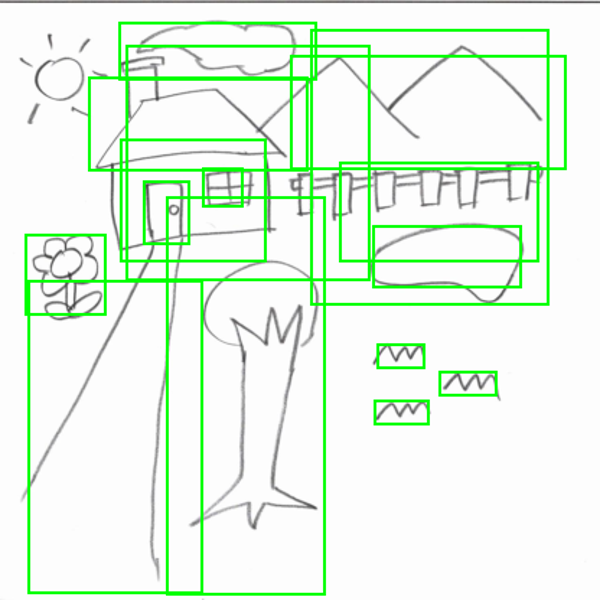

In [11]:
@torch.no_grad()
def infer_image(img_path, conf_th=0.15, iou_th=0.45):
    im = Image.open(img_path).convert("RGB")
    im_lb, s, px, py = letterbox(im, INPUT_SIZE)
    arr = np.transpose(np.asarray(im_lb, np.float32) / 255.0, (2, 0, 1))
    t = torch.from_numpy(arr).unsqueeze(0).to(DEVICE)

    out = model(t)  # dict: {13: ..., 26: ..., 52: ...}
    boxes_all, scores_all, labels_all = [], [], []

    for S in [13, 26, 52]:
        pred = out[S][0].cpu().numpy()  # (3, S, S, 5+C)
        stride = INPUT_SIZE // S
        anchors = np.array(ANCHORS_SCALED[S], np.float32)

        for a in range(3):
            for gy in range(S):
                for gx in range(S):
                    tx, ty, tw, th, to = pred[a, gy, gx, :5]
                    obj = 1 / (1 + np.exp(-to))

                    # 클래스 확률 계산은 그대로 두되(필터링 일관성), 시각화에는 사용 안함
                    cls_logits = pred[a, gy, gx, 5:]
                    if cls_logits.size > 0:
                        cls_prob = 1 / (1 + np.exp(-cls_logits))
                        cidx = int(np.argmax(cls_prob))
                        conf = obj * cls_prob[cidx]
                    else:
                        conf = obj

                    if conf < conf_th:
                        continue

                    cx = (1 / (1 + np.exp(-tx)) + gx) * stride
                    cy = (1 / (1 + np.exp(-ty)) + gy) * stride
                    bw = anchors[a, 0] * np.exp(tw)
                    bh = anchors[a, 1] * np.exp(th)

                    x1, y1, x2, y2 = cx - bw / 2, cy - bh / 2, cx + bw / 2, cy + bh / 2
                    boxes_all.append([x1, y1, x2, y2])
                    scores_all.append(float(conf))
                    labels_all.append(0)  # 레이블은 사용하지 않지만 NMS 루프 구조를 위해 더미로 0

    if len(boxes_all) == 0:
        return im_lb, ([], [], [])

    boxes_all = np.array(boxes_all, np.float32)
    scores_all = np.array(scores_all, np.float32)
    labels_all = np.array(labels_all, np.int32)

    # 클래스별 NMS이지만, 지금은 모두 같은 '탐지만'이라 0 하나뿐
    final_boxes, final_scores, final_labels = [], [], []
    for c in np.unique(labels_all):
        idxs = np.where(labels_all == c)[0]
        keep = nms_np(boxes_all[idxs], scores_all[idxs], iou_th)
        for k in keep:
            final_boxes.append(boxes_all[idxs][k].tolist())
            final_scores.append(float(scores_all[idxs][k]))
            final_labels.append(int(c))

    # === 박스만 그리기 ===
    draw = im_lb.copy()
    dr = ImageDraw.Draw(draw)
    W, H = draw.size
    box_th = max(2, int(max(W, H) / 512 * 2))

    for (x1, y1, x2, y2) in final_boxes:
        dr.rectangle([x1, y1, x2, y2], outline=(0, 255, 0), width=box_th)

    return draw, (final_boxes, final_scores, final_labels)

# 샘플 1장 시각화 (박스만)
sample_img = train_items[66]["img_path"] if len(train_items := train_items if 'train_items' in globals() else [items[0]]) > 0 else items[0]["img_path"]
drawn, _ = infer_image(sample_img)
display(drawn.resize((600, 600)))

In [12]:
import os, shutil
from pathlib import Path
from PIL import Image

def export_classifier_crops_from_gt(items, out_dir="cls_crops_gt", min_size=8):
    """
    items: [{"img_path":..., "bboxes":[{"x","y","w","h","label"}, ...]}, ...]
    out_dir: ImageFolder 구조로 저장 (label/xxx.jpg)
    """
    out = Path(out_dir)
    if out.exists():
        shutil.rmtree(out)
    out.mkdir(parents=True, exist_ok=True)

    n_ok = 0
    for it in items:
        img_path = it["img_path"]
        im = Image.open(img_path).convert("RGB")
        W, H = im.size
        for i, bb in enumerate(it["bboxes"]):
            x, y, w, h = float(bb["x"]), float(bb["y"]), float(bb["w"]), float(bb["h"])
            if w < min_size or h < min_size:
                continue
            x1, y1 = int(max(0, x)), int(max(0, y))
            x2, y2 = int(min(W, x + w)), int(min(H, y + h))
            if x2 <= x1 or y2 <= y1:
                continue
            crop = im.crop((x1, y1, x2, y2))
            cls_name = str(bb.get("label", "unknown"))
            cls_dir = out / cls_name
            cls_dir.mkdir(parents=True, exist_ok=True)
            save_name = f"{Path(img_path).stem}_{i}.jpg"
            crop.save(cls_dir / save_name, quality=95)
            n_ok += 1
    print(f"[OK] saved {n_ok} crops to {out.resolve()}")
    return out.resolve()

train_crops_dir = export_classifier_crops_from_gt(train_items, "cls_crops_gt_train")
val_crops_dir   = export_classifier_crops_from_gt(val_items,   "cls_crops_gt_val")

[OK] saved 12419 crops to /content/cls_crops_gt_train
[OK] saved 1386 crops to /content/cls_crops_gt_val


In [13]:
import torch, torchvision
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
from pathlib import Path

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mean = (0.485, 0.456, 0.406)
std  = (0.229, 0.224, 0.225)

tf_train = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
tf_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

ds_train = torchvision.datasets.ImageFolder(Path("cls_crops_gt_train"), tf_train)
ds_val   = torchvision.datasets.ImageFolder(Path("cls_crops_gt_val"),   tf_val)
num_classes_cls = len(ds_train.classes)
cls_idx2name = {i:n for i,n in enumerate(ds_train.classes)}

dl_train = DataLoader(ds_train, batch_size=64, shuffle=True,  num_workers=2, pin_memory=True)
dl_val   = DataLoader(ds_val,   batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

def build_resnet18(num_classes):
    try:
        m = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
    except Exception:
        m = torchvision.models.resnet18(weights=None)
    in_f = m.fc.in_features
    m.fc = nn.Linear(in_f, num_classes)
    return m

cls_model = build_resnet18(num_classes_cls).to(DEVICE)
opt = torch.optim.Adam(cls_model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion_ce = nn.CrossEntropyLoss()

def train_cls_ep():
    cls_model.train(); total=0.0; correct=0; n=0
    for x,y in dl_train:
        x,y = x.to(DEVICE), y.to(DEVICE)
        logits = cls_model(x)
        loss = criterion_ce(logits, y)
        opt.zero_grad(); loss.backward(); opt.step()
        total += loss.item()*y.size(0)
        pred = logits.argmax(1)
        correct += (pred==y).sum().item(); n += y.size(0)
    return total/n, correct/n

@torch.no_grad()
def val_cls_ep():
    cls_model.eval(); total=0.0; correct=0; n=0
    for x,y in dl_val:
        x,y = x.to(DEVICE), y.to(DEVICE)
        logits = cls_model(x)
        loss = criterion_ce(logits, y)
        total += loss.item()*y.size(0)
        pred = logits.argmax(1)
        correct += (pred==y).sum().item(); n += y.size(0)
    return total/n, correct/n

EPOCHS = 5  # 데이터 양에 따라 5~20
best = 0.0
for ep in range(1, EPOCHS+1):
    tl, ta = train_cls_ep()
    vl, va = val_cls_ep()
    print(f"[{ep:02d}] train loss {tl:.3f} acc {ta:.3f} | val loss {vl:.3f} acc {va:.3f}")
    if va > best:
        best = va
        torch.save({"model": cls_model.state_dict(), "classes": ds_train.classes}, "cls_resnet18_best.pt")
        print("  ↳ best classifier saved")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:01<00:00, 42.2MB/s]


[01] train loss 1.560 acc 0.554 | val loss 1.632 acc 0.532
  ↳ best classifier saved
[02] train loss 1.075 acc 0.679 | val loss 1.755 acc 0.507
[03] train loss 0.949 acc 0.711 | val loss 2.453 acc 0.379
[04] train loss 0.837 acc 0.740 | val loss 1.348 acc 0.626
  ↳ best classifier saved
[05] train loss 0.771 acc 0.759 | val loss 4.191 acc 0.260


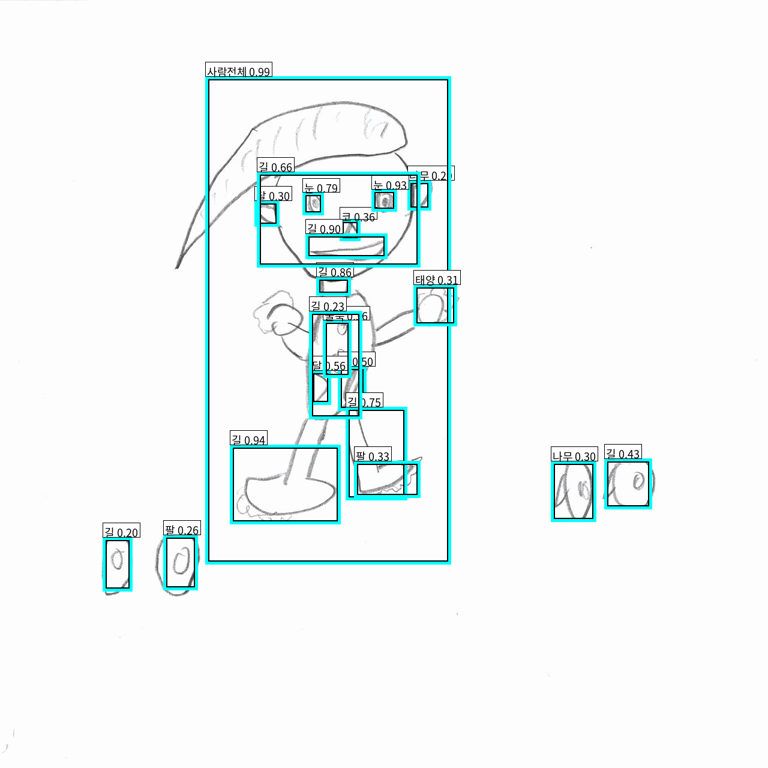

{'box_orig': [566, 365, 600, 401], 'det_conf': 0.9979618191719055, 'det_yolo_class': '가지', 'cls_name': '코', 'cls_score': 0.3562731146812439}
{'box_orig': [504, 320, 539, 358], 'det_conf': 0.9922784566879272, 'det_yolo_class': '가지', 'cls_name': '눈', 'cls_score': 0.788906991481781}
{'box_orig': [424, 334, 465, 377], 'det_conf': 0.9877209067344666, 'det_yolo_class': '가지', 'cls_name': '달', 'cls_score': 0.2990444600582123}
{'box_orig': [679, 300, 718, 350], 'det_conf': 0.9873524904251099, 'det_yolo_class': '가지', 'cls_name': '나무', 'cls_score': 0.28850650787353516}
{'box_orig': [563, 610, 610, 684], 'det_conf': 0.8701831698417664, 'det_yolo_class': '가지', 'cls_name': '달', 'cls_score': 0.4973175823688507}
{'box_orig': [527, 461, 584, 492], 'det_conf': 0.8032703995704651, 'det_yolo_class': '가지', 'cls_name': '길', 'cls_score': 0.855218768119812}
{'box_orig': [428, 286, 700, 445], 'det_conf': 0.7933364510536194, 'det_yolo_class': '가지', 'cls_name': '길', 'cls_score': 0.6598973274230957}
{'box_orig': 

In [14]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import torch
import torch.nn.functional as F

def _get_font(size=18):
    paths = [
        "/usr/share/fonts/truetype/noto/NotoSansCJK-Regular.ttc",
        "/usr/share/fonts/truetype/noto/NotoSansCJK-Regular.otf",
        "/Library/Fonts/AppleGothic.ttf",
        "C:/Windows/Fonts/malgun.ttf",
    ]
    for p in paths:
        try:
            return ImageFont.truetype(p, size)
        except:
            pass
    return ImageFont.load_default()

def de_letterbox_xyxy(x1,y1,x2,y2, scale, pad_x, pad_y):
    ox1 = (x1 - pad_x) / scale
    oy1 = (y1 - pad_y) / scale
    ox2 = (x2 - pad_x) / scale
    oy2 = (y2 - pad_y) / scale
    return ox1, oy1, ox2, oy2

@torch.no_grad()
def detect_then_classify(img_path, conf_th=0.15, iou_th=0.45):
    """
    YOLO infer_image() 결과를 받아 원본 좌표로 역보정 → crop → 분류 → 최종 라벨.
    반환: (preds: list, vis_img: PIL)
    """
    # 1) letterbox 파라미터 계산 (infer_image와 동일 INPUT_SIZE 사용)
    im = Image.open(img_path).convert("RGB")
    im_lb, scale, pad_x, pad_y = letterbox(im, INPUT_SIZE)

    # 2) YOLO 추론 호출 — ✅ 모델 인자 제거, 키워드 중복 제거
    drawn, detection_results = infer_image(img_path, conf_th=conf_th, iou_th=iou_th)
    lb_boxes, lb_scores, lb_labels = detection_results

    preds = []
    for (x1,y1,x2,y2), s, yolo_c in zip(lb_boxes, lb_scores, lb_labels):
        # 3) 원본 좌표로 역보정
        ox1, oy1, ox2, oy2 = de_letterbox_xyxy(x1,y1,x2,y2, scale, pad_x, pad_y)
        ox1, oy1 = int(max(0, ox1)), int(max(0, oy1))
        ox2, oy2 = int(min(im.width, ox2)), int(min(im.height, oy2))
        if ox2 <= ox1 or oy2 <= oy1:
            continue
        crop = im.crop((ox1, oy1, ox2, oy2))

        # 4) 분류
        x = tf_val(crop).unsqueeze(0).to(DEVICE)  # tf_val: 위에서 정의한 전처리
        logits = cls_model(x)
        prob = F.softmax(logits, dim=1)[0]
        cid = int(prob.argmax().item())
        cname = cls_idx2name[cid]
        cscore = float(prob.max().item())

        preds.append({
            "box_orig": [ox1,oy1,ox2,oy2],
            "det_conf": float(s),
            "det_yolo_class": idx2cls.get(int(yolo_c), str(yolo_c)) if 'idx2cls' in globals() else int(yolo_c),
            "cls_name": cname,
            "cls_score": cscore,
        })

    # 5) 최종 시각화 (분류 라벨 기준, 시안색)
    draw = im.copy()
    dr = ImageDraw.Draw(draw)
    font = _get_font(18)
    W,H = draw.size
    thick = max(2, int(max(W,H)/512*2)); pad = 3
    for p in preds:
        x1,y1,x2,y2 = p["box_orig"]
        dr.rectangle([x1,y1,x2,y2], outline=(0,0,0), width=thick+2)
        dr.rectangle([x1,y1,x2,y2], outline=(0,255,255), width=thick)
        text = f"{p['cls_name']} {p['cls_score']:.2f}"
        tx1,ty1,tx2,ty2 = dr.textbbox((0,0), text, font=font)
        tw, th = tx2-tx1, ty2-ty1
        bx1 = max(0, x1); by1 = y1 - th - 2*pad
        if by1 < 0: by1 = y1
        bx2 = min(W, bx1 + tw + 2*pad); by2 = min(H, by1 + th + 2*pad)
        dr.rectangle([bx1,by1,bx2,by2], fill=(255,255,255))
        dr.rectangle([bx1,by1,bx2,by2], outline=(0,0,0), width=1)
        dr.text((bx1+pad,by1+pad), text, fill=(0,0,0), font=font)

    return preds, draw

# === 한 장 테스트 ===
sample_img = train_items[30]["img_path"]
preds, vis = detect_then_classify(sample_img, conf_th=0.15, iou_th=0.45)
display(vis.resize((768,768)))
for p in preds:
    print(p)